### Detecting temporal coordination of high-power bursts

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [2]:
import itertools
import os

import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numba as nb
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from frites.conn.conn_spec import conn_spec
from frites.conn.conn_tf import _tf_decomp
from frites.utils import parallel_func
from scipy.signal import find_peaks
from tqdm import tqdm

from config import sessions
from GDa.session import session, session_info
from GDa.signal.surrogates import trial_swap_surrogates
from GDa.temporal_network import temporal_network
from GDa.util import _extract_roi, average_stages, create_stages_time_grid

In [3]:
#
def compute_quantile_thresholds(tensor, q=0.8, verbose=False, n_jobs=1):
    """
    Compute the power/coherence thresholds for the data
    Parameters
    ----------
    tensor: array_like
        Data with dimensions (nodes/links,bands,observations)
        or (nodes/links,bands,trials,time)
    q: array_like | 0.8
        Quantile value to use as threshold
    relative: bool | False
        If True compute one threshold for each node/link
        in each band (defalta False)
    Returns
    -------
    thr: array_like
        Threshold values, if realtive is True it will have
        dimensions ("links","bands","trials") otherwise ("bands","trials")
        (if tensor shape is 3 there is no "trials" dimension)
    """

    n_bands = tensor.sizes["freqs"]

    tensor_ft = tensor.stack(z=("trials", "roi", "times")).data

    # To compute in parallel for each band
    # @nb.njit
    def _for_band(b):
        return np.quantile(tensor_ft[b, ...], q)

    thr = [_for_band(b) for b in range(n_bands)]

    return thr

#### Load power

In [4]:
tt = 1
br = 1
at = "cue"
session = "141024"

_ROOT = os.path.expanduser("~/funcog/gda")
_FILE_NAME = f"power_tt_{tt}_br_{br}_at_{at}.nc"

power = xr.load_dataarray(
    os.path.join(_ROOT, f"Results/lucy/{session}/session01", _FILE_NAME)
)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.19it/s]


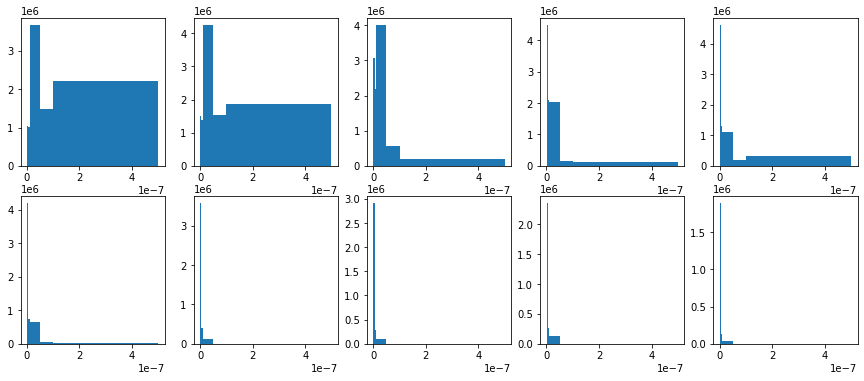

In [5]:
bins = np.array([1e-9, 5e-9, 1e-8, 5e-8, 1e-7, 5e-7])

plt.figure(figsize=(15, 6))
for f in tqdm(range(power.sizes["freqs"])):
    plt.subplot(2, 5, f + 1)
    plt.hist(power.isel(freqs=f).data.flatten(), bins=bins)

#### Filtring power activations

In [6]:
quantiles = np.linspace(0.5, 0.99, 10)

In [7]:
unique_rois = np.unique(power.roi.data)

In [8]:
ntrials = power.sizes["trials"]
nfreqs = power.sizes["freqs"]
nrois = power.sizes["roi"]  # len(unique_rois)
nthr = len(quantiles)

In [9]:
thresholds = np.zeros((nfreqs, nthr))

In [10]:
for t in tqdm(range(nthr)):
    thresholds[:, t] = compute_quantile_thresholds(power, quantiles[t])

100%|█████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.81s/it]


Text(0.5, 0, 'quantile')

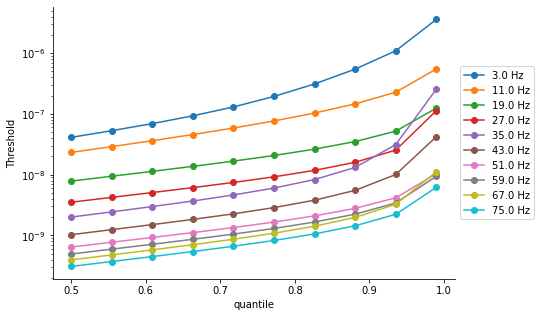

In [11]:
plt.figure(figsize=(9, 5))
ax = plt.subplot(111)
for i in range(10):
    plt.semilogy(quantiles, thresholds[i], "o-", label=f"{power.freqs.data[i]} Hz")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.ylabel("Threshold")
plt.xlabel("quantile")

In [12]:
n_act = np.zeros((nrois, nfreqs, nthr))

for f in tqdm(range(nfreqs)):
    for t in range(nthr):
        N_power = power.isel(freqs=f) > thresholds[f, t]
        n_act[:, f, t] = N_power.mean(("trials", "times"))

n_act = xr.DataArray(
    n_act, dims=("roi", "freqs", "thr"), coords=(power.roi, power.freqs, quantiles)
)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.39it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.65it/s]


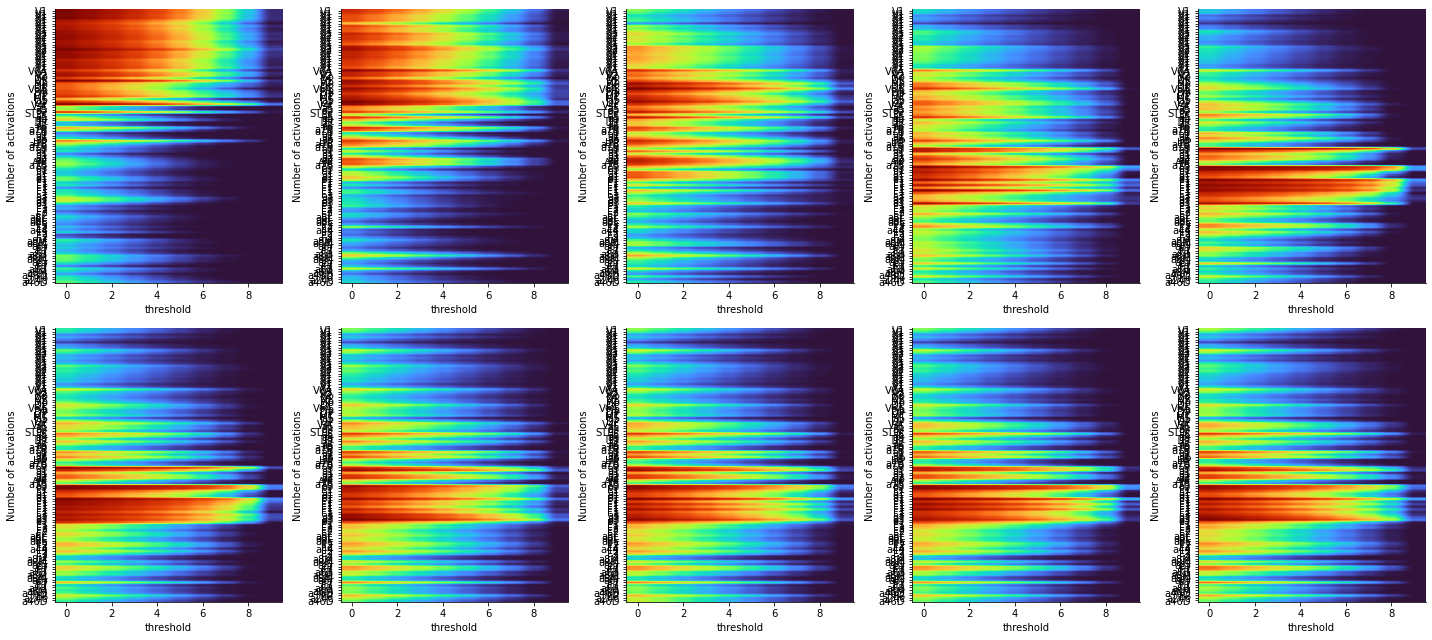

In [13]:
plt.figure(figsize=(20, 9))
for f in tqdm(range(nfreqs)):
    ax = plt.subplot(2, 5, f + 1)
    plt.imshow(n_act.isel(freqs=f), aspect="auto", origin="lower", cmap="turbo")
    plt.ylabel("Number of activations")
    plt.xlabel("threshold")
    plt.yticks(range(nrois), power.roi.data)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
plt.tight_layout()

#### Load coherence

In [14]:
coh_file = f"coh_at_cue.nc"
coh_sig_file = f"thr_coh_at_cue_surr.nc"

In [15]:
net = temporal_network(
    coh_file=coh_file,
    coh_sig_file=None,
    wt=None,
    date=session,
    trial_type=[1],
    behavioral_response=[1],
)

In [16]:
thresholds_coh = np.zeros((nfreqs, nthr))

In [17]:
for t in tqdm(range(nthr)):
    thresholds_coh[:, t] = compute_quantile_thresholds(net.super_tensor, quantiles[t])

100%|█████████████████████████████████████████████████████████████████████████████████████████| 10/10 [09:36<00:00, 57.67s/it]


In [18]:
unique_edges = np.unique(net.super_tensor.roi.data)

n_act_coh = np.zeros((net.super_tensor.sizes["roi"], nfreqs, nthr))

for f in tqdm(range(nfreqs)):
    for t in range(nthr):
        N_coh = net.super_tensor.isel(freqs=f) > thresholds_coh[f, t]
        n_act_coh[:, f, t] = N_coh.mean(("trials", "times"))

n_act_coh = xr.DataArray(
    n_act_coh,
    dims=("roi", "freqs", "thr"),
    coords=(net.super_tensor.roi.data, power.freqs, quantiles),
)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:51<00:00, 11.15s/it]


Text(0.5, 0, 'quantile')

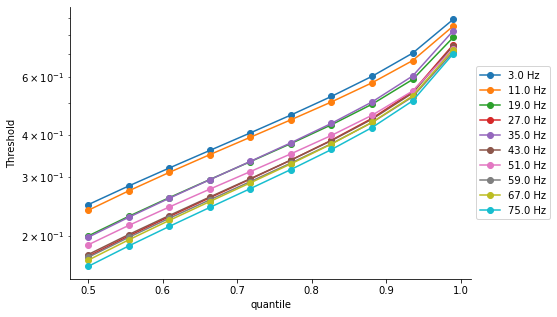

In [19]:
plt.figure(figsize=(9, 5))
ax = plt.subplot(111)
for i in range(10):
    plt.semilogy(quantiles, thresholds_coh[i], "o-", label=f"{power.freqs.data[i]} Hz")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.ylabel("Threshold")
plt.xlabel("quantile")

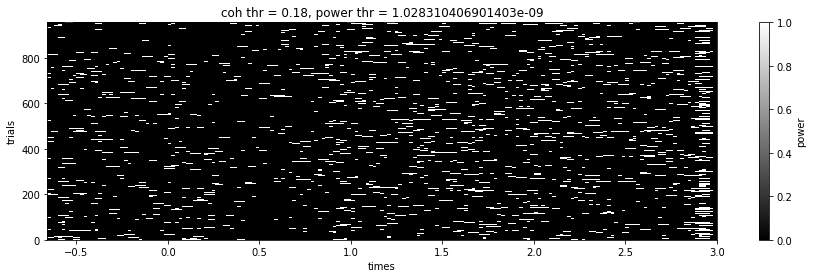

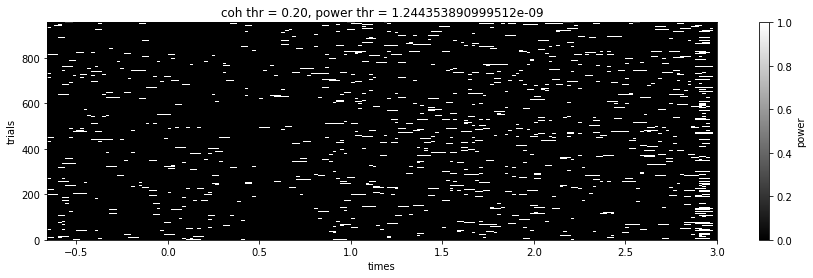

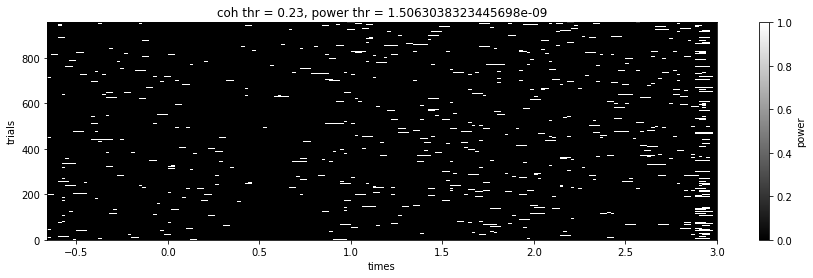

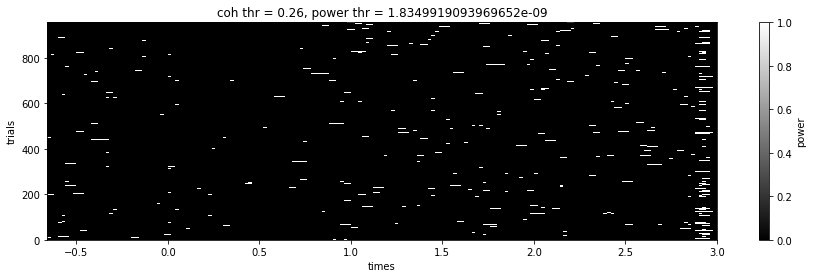

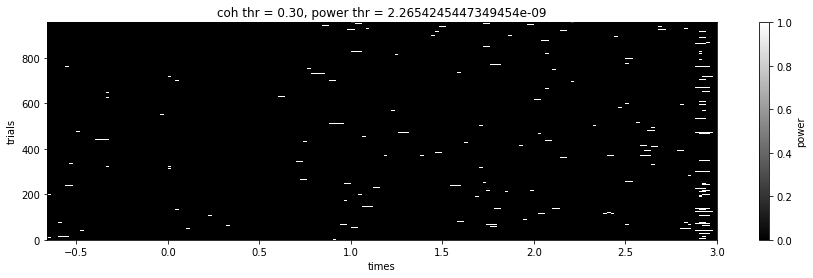

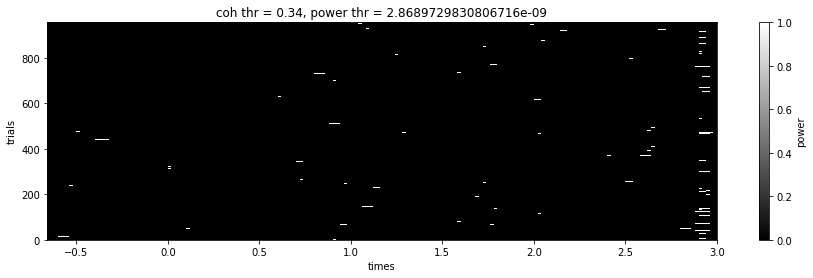

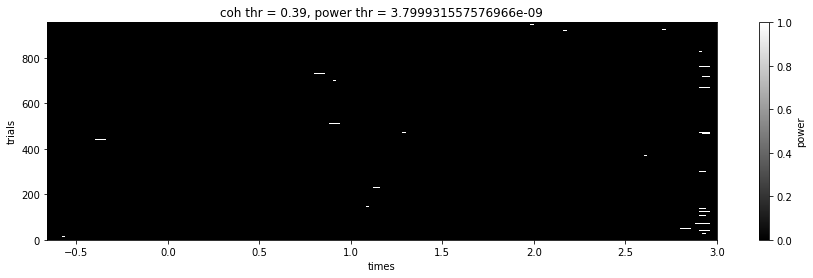

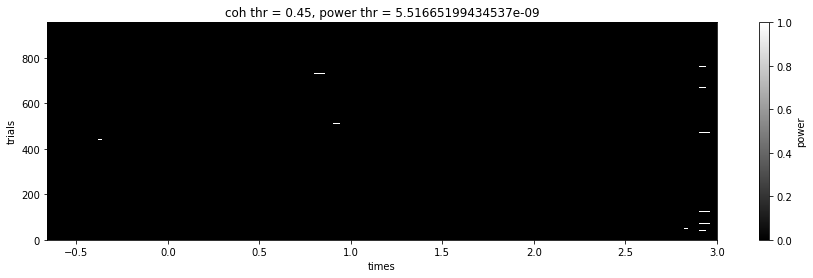

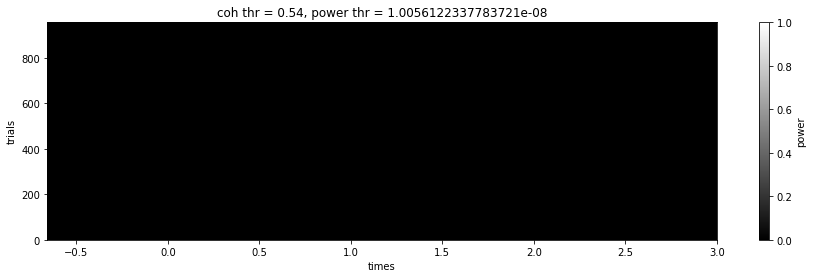

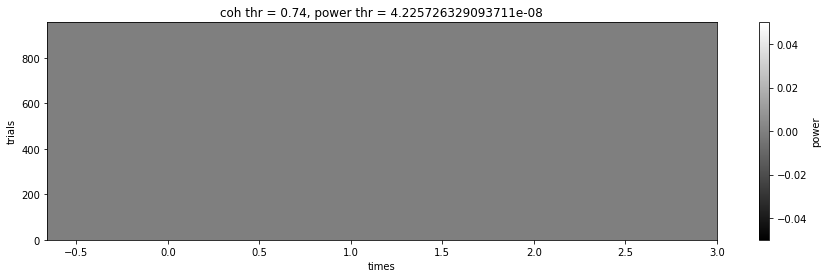

In [20]:
for i in range(10):
    plt.figure(figsize=(15, 4))
    a = (power.isel(roi=-6, freqs=5) > thresholds[5, i]).astype(int) * (
        power.isel(roi=39, freqs=5) > thresholds[5, i]
    ).astype(int)
    a.plot.imshow(x="times", y="trials", origin="lower", cmap="binary_r")
    plt.title(f"coh thr = {thresholds_coh[5, i]:.2f}, power thr = {thresholds[5, i]}")

- N(power(i) > Thr(Q)) / N_tot as a function of Q
    i.e. how many strong bursts have a region in a band
- N(coherence(ij) > Thr(Q)) / N_tot as a function of Q
    i.e. how many strong bursts have a link in a band
- N(power(i) > Thr(Q_pow)) / N(coherence(ij) > Thr(Q_coh)) as a function of Q_pow (quantile for power) and Q_coh (quantile for coherence)
    i.e. how many times there is a strong power burst in a region when it is involved in a strong coherence link
- N( (power(i) > Thr(Q)) AND (power(j) > Thr(Q)) ) / N(power(i) > Thr(Q)) as a function of Q
    i.e. how many of the strong bursts of a region in a band match with strong bursts in another region
- N( (power(i) > Thr(Q_pow)) AND (power(j) > Thr(Q_pow)) ) / N(coherence(ij) > Thr(Q_coh)) as a function of Q_pow (quantile for power) and Q_coh (quantile for coherence)
    i.e. how many of the strong bursts of a region in a band match with strong bursts in another region when the coherence between the two regions is high

In [21]:
thr = thresholds[5, 6]
thr_coh = thresholds_coh[5, 6]

In [22]:
idx = (power.isel(roi=39, freqs=5) > thr) * (power.isel(roi=-6, freqs=5) > thr)

In [23]:


nF1 = power.isel(roi=39, freqs=5) * idx
nV1 = power.isel(roi=-6, freqs=5) * idx

#nF1 = (nF1 - nF1.mean("times")) / nF1.std("times")
#nV1 = (nV1 - nV1.mean("times")) / nV1.std("times")

Text(0.5, 1.0, 'F1')

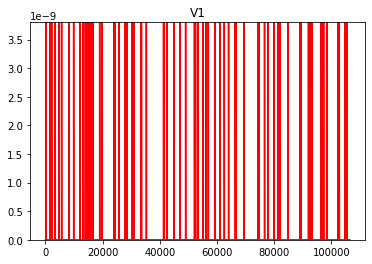

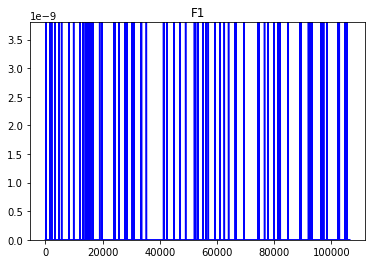

In [24]:
plt.figure()
plt.plot(nV1.data.flatten(), color="r")
plt.ylim(0, thr)
plt.title("V1")
plt.figure()
plt.plot(nF1.data.flatten(), color="b")
plt.ylim(0, thr)
plt.title("F1")

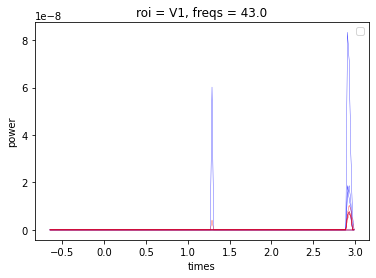

In [25]:
nF1.isel(trials=(power.isel(roi=-6, freqs=-2) > thr).sum("times") > 0).plot(
    x="times", hue="trials", color="b", lw=0.3
)
nV1.isel(trials=(power.isel(roi=-6, freqs=-2) > thr).sum("times") > 0).plot(
    x="times", hue="trials", color="r", lw=0.3
)
plt.legend([]);

In [26]:
a = []
b = []
c = []
d = []
e = []
f = []
g = []
for i in range(10):
    nF1_V1 = net.super_tensor.isel(roi=3374, freqs=-2) > thresholds_coh[-2, i]

    nF1 = (power.isel(roi=39, freqs=-2) > thresholds[-2, i]).astype(int)
    nV1 = (power.isel(roi=-6, freqs=-2) > thresholds[-2, i]).astype(int)

    a += [(nF1 * nV1).sum() / nF1.sum()]
    b += [(nF1 * nV1).sum() / nV1.sum()]
    c += [nF1.mean()]
    d += [nV1.mean()]
    e += [(nF1 * nV1).sum() / nF1_V1.sum()]
    f += [nF1.sum() / nF1_V1.sum()]
    g += [nV1.sum() / nF1_V1.sum()]

Text(0.5, 1.0, 'V1')

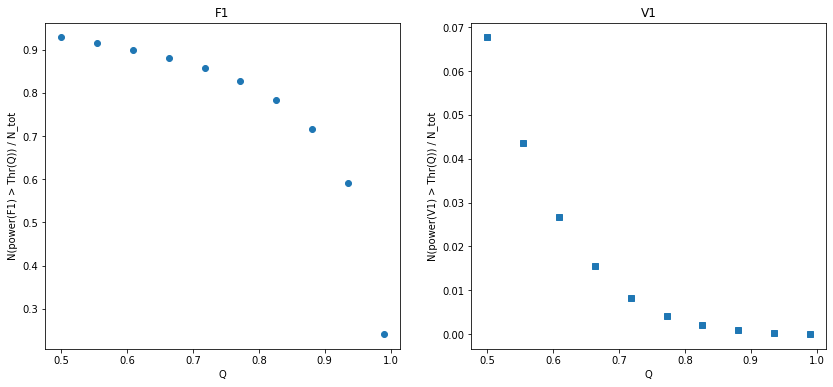

In [27]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(quantiles, c, "o")
plt.ylabel("N(power(F1) > Thr(Q)) / N_tot")
plt.xlabel("Q")
plt.title("F1")

plt.subplot(1, 2, 2)
plt.plot(quantiles, d, "s")
plt.ylabel("N(power(V1) > Thr(Q)) / N_tot")
plt.xlabel("Q")
plt.title("V1")

Text(0.5, 1.0, 'normed by coh(V1,F1)')

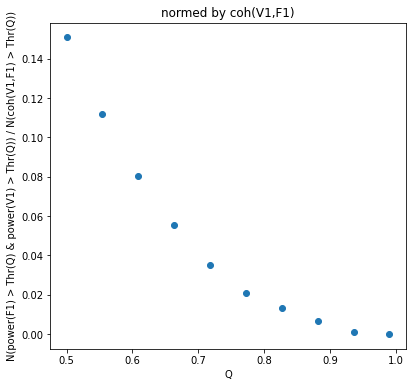

In [28]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(quantiles, e, "o")
plt.ylabel("N(power(F1) > Thr(Q) & power(V1) > Thr(Q)) / N(coh(V1,F1) > Thr(Q))")
plt.xlabel("Q")
plt.title("normed by coh(V1,F1)")

Text(0.5, 1.0, 'normed by coh(V1,F1)')

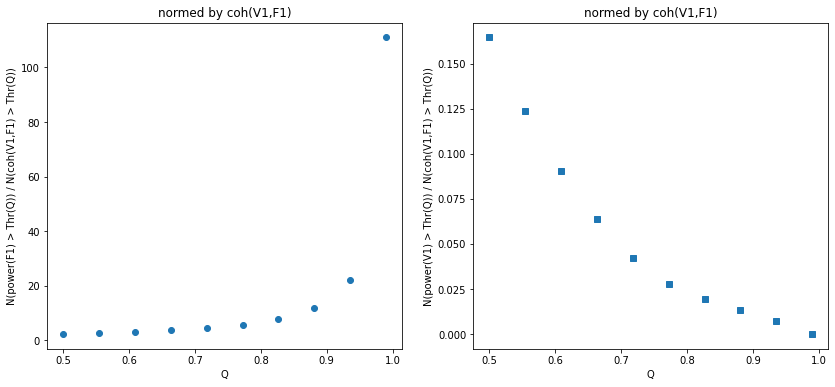

In [29]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(quantiles, f, "o")
plt.ylabel("N(power(F1) > Thr(Q)) / N(coh(V1,F1) > Thr(Q))")
plt.xlabel("Q")
plt.title("normed by coh(V1,F1)")

plt.subplot(1, 2, 2)
plt.plot(quantiles, g, "s")
plt.ylabel("N(power(V1) > Thr(Q)) / N(coh(V1,F1) > Thr(Q))")
plt.xlabel("Q")
plt.title("normed by coh(V1,F1)")

In [30]:
channel_labels = net.super_tensor.channels_labels
sources, targets = net.super_tensor.sources, net.super_tensor.targets

win = [[-0.5, 0], [0.0, 0.5], [0.5, 1.0], [1.0, 1.5], [1.5, 2.0], [2.0, 2.5]]

probs = np.zeros((net.super_tensor.sizes["roi"], len(win), len(quantiles)))

for i in tqdm(range(10)):
    p = 0
    for s, t in zip(sources, targets):

        ncohij = (net.super_tensor.isel(roi=p, freqs=5) > thresholds_coh[5, i]).astype(
            int
        )
        npowi = (power.isel(roi=s, freqs=5) > thresholds[5, i]).astype(int)
        npowj = (power.isel(roi=t, freqs=5) > thresholds[5, i]).astype(int)

        for wi, (wl, wu) in enumerate(win):

            norm = 1 / ncohij.sel(times=slice(wl, wu)).sum()

            probs[p, wi, i] = (
                (npowi * npowj * ncohij).sel(times=slice(wl, wu)).sum()
            ) * norm

        p = p + 1

100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [20:57<00:00, 125.73s/it]


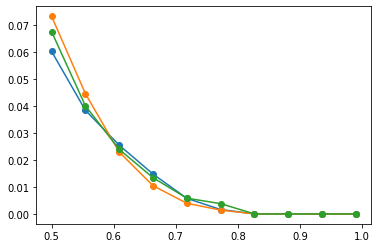

In [31]:
plt.plot(quantiles, probs[3374, 3:, :].T, "o-")

In [32]:
probs[3374, ...].T.shape

(10, 6)

In [33]:
probs[0]

array([[0.19810486, 0.14754791, 0.1096805 , 0.0727802 , 0.04217512,
        0.02098274, 0.00952717, 0.00109349, 0.        , 0.        ],
       [0.20216203, 0.15298662, 0.11261261, 0.07606945, 0.04181626,
        0.02076391, 0.00605042, 0.        , 0.        , 0.        ],
       [0.19161119, 0.1420092 , 0.09927889, 0.06559624, 0.03952941,
        0.01905896, 0.00435816, 0.00059207, 0.        , 0.        ],
       [0.20050955, 0.1450134 , 0.09913931, 0.06056701, 0.0306056 ,
        0.01321702, 0.00441276, 0.        , 0.        , 0.        ],
       [0.20327588, 0.15588633, 0.11062415, 0.07384403, 0.04424599,
        0.01735681, 0.00807494, 0.00190295, 0.        , 0.        ],
       [0.21395798, 0.15715423, 0.11019567, 0.07531381, 0.04477612,
        0.0244663 , 0.00622665, 0.00091241, 0.        , 0.        ]])

Text(0.5, 0, 'Power F1')

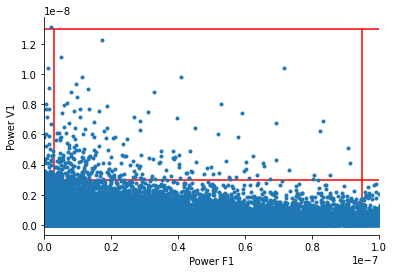

In [70]:
ax = plt.subplot(111)
plt.plot( power.isel(roi=39, freqs=5).data.flatten(), power.isel(roi=-6, freqs=5).data.flatten(), '.' );
plt.xlim(0,1e-7)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.hlines(3e-9, 0, 5e-7, 'r')
plt.hlines(1.3e-8, 0, 5e-7, 'r')
plt.vlines(3e-9, 0, 1.3e-8, 'r')
plt.vlines(0.95e-7, 0, 1.3e-8, 'r')
plt.ylabel("Power V1")
plt.xlabel("Power F1")

(0.0, 10000000.0)

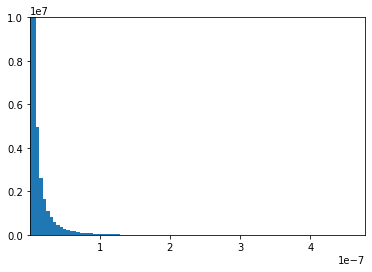

In [86]:
plt.hist(power.isel(freqs=5).data.flatten(), 100, density=True);
plt.xlim(1e-9, power.isel(freqs=5).max())
plt.ylim(0, 1e7)

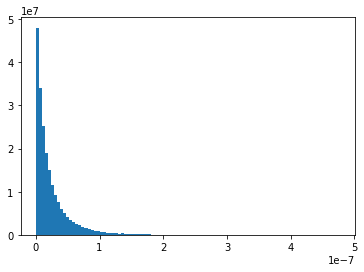

In [87]:
plt.hist(power.isel(roi=39, freqs=5).data.flatten(), 100, density=True);


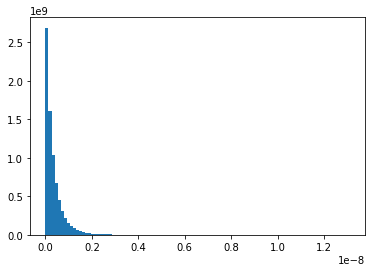

In [88]:
plt.hist(power.isel(roi=-6, freqs=5).data.flatten(), 100, density=True);
